# Performance Comparison of Data Loading Libraries for CSV and PC-Axis (.px) Files

This notebook compares the performance of different Python libraries when reading CSV and PC-Axis (.px) datasets. We will evaluate:

- **CSV Libraries**: pandas, polars, dask
- **.px Libraries**: `pyaxis`

For each library, we measure:

1. **Load Time** (seconds)
2. **Peak Memory Usage** (MB)
3. **CPU Utilization** (%)

At the end, we summarize which library is the most optimized in terms of speed, memory, and CPU usage for each file type, and compare CSV vs PC-Axis performance.

# Import all libraries here

In [1]:
import time
import os
import psutil
import pandas as pd
import polars as pl
import dask.dataframe as dd
from pyaxis import pyaxis
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

# Utility to measure load performance

In [2]:
def measure_perf(func, interval=0.1):
    """
    Runs `func` and returns:
      - time_s: total elapsed seconds
      - peak_mem_mb: peak RAM usage during run (MB)
      - avg_cpu_percent: average CPU utilization (%)
    Also returns the function's return value.
    """
    proc = psutil.Process(os.getpid())
    # Measure memory over time
    start_time = time.time()
    mem_usage, result = memory_usage((func,), interval=interval, retval=True)
    end_time = time.time()
    duration = end_time - start_time
    peak_mem_mb = max(mem_usage) - min(mem_usage)
    # Sample CPU usage during run
    cpu_readings = []
    samples = int(duration / interval) or 1
    for _ in range(samples):
        cpu_readings.append(proc.cpu_percent(interval=interval))
    avg_cpu = sum(cpu_readings) / len(cpu_readings)
    perf = {'time_s': duration, 'peak_mem_mb': peak_mem_mb, 'avg_cpu_percent': avg_cpu}
    return perf, result

# 1. CSV Benchmarking: pandas, polars, dask

In [3]:
def profile_chunks(path, chunksize=100000):
    """Compare pandas.read_csv full vs chunked."""
    full_perf, _ = measure_perf(lambda: pd.read_csv(path))
    chunked_perf, _ = measure_perf(
        lambda: pd.concat(pd.read_csv(path, chunksize=chunksize)), interval=0.2
    )
    return {'full': full_perf, 'chunked': chunked_perf}

# Containers
results = {'csv': {}, 'px': {}, 'chunks': {}}

In [4]:
csv_files = {
    'exports_values': 'datasets/12100094.csv',
    'non_res_buildings': 'datasets/18100289.csv',
}

In [5]:
for name, path in csv_files.items():
    results['csv'][name] = {}
    results['csv'][name]['pandas'], _ = measure_perf(lambda: pd.read_csv(path))
    results['csv'][name]['polars'], _ = measure_perf(lambda: pl.read_csv(path))
    # Specify dtypes to avoid mismatches in Dask
    results['csv'][name]['dask'], _ = measure_perf(
        lambda: dd.read_csv(path, dtype={'STATUS': 'object', 'VALUE': 'float64'}).compute()
    )
    # chunked pandas profiling
    results['chunks'][name]     = profile_chunks(path)

In [6]:
print("CSV Results:")
for name, perf in results['csv'].items():
    print(f"{name}:")
    for lib, metrics in perf.items():
        print(f"  {lib}: {metrics}")

CSV Results:
exports_values:
  pandas: {'time_s': 1.257493019104004, 'peak_mem_mb': 11.34765625, 'avg_cpu_percent': 0.0}
  polars: {'time_s': 2.203700065612793, 'peak_mem_mb': 7.05859375, 'avg_cpu_percent': 0.7545454545454546}
  dask: {'time_s': 1.2407946586608887, 'peak_mem_mb': 19.9375, 'avg_cpu_percent': 0.0}
non_res_buildings:
  pandas: {'time_s': 0.9326224327087402, 'peak_mem_mb': 54.734375, 'avg_cpu_percent': 1.588888888888889}
  polars: {'time_s': 1.3057396411895752, 'peak_mem_mb': 122.421875, 'avg_cpu_percent': 0.0}
  dask: {'time_s': 1.1276259422302246, 'peak_mem_mb': 127.33984375, 'avg_cpu_percent': 0.0}


# 2. PC‑Axis (.px) Benchmarking: pyaxis only

In [7]:
px_files = {
    'building_index': 'datasets/BEQ04.20250701105442.px',
    'trade_stats':   'datasets/TSA11.20250701105539.px',
}

In [8]:
for name, path in px_files.items():
    perf, _ = measure_perf(lambda: pyaxis.read(path, encoding='utf-16-le'))
    results['px'][name] = {'pyaxis': perf}

# 3. Results Summary & Automated Analysis

=== Best Loader Overall ===
type            csv_chunk
dataset    exports_values
library       pandas_full
score            0.098822
Name: 8, dtype: object
Fastest: pandas (0.93s)
Lowest Memory: pyaxis (0.0 MB)
Lowest CPU: pandas (0.0% CPU)

Adjust weights to emphasize speed vs memory vs CPU as needed.


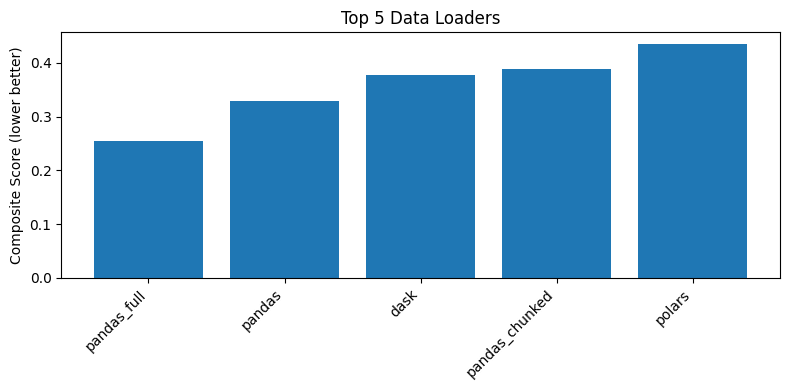

In [9]:
# Flatten results
data_rows = []
for dtype in ['csv', 'px']:
    for ds, libs in results[dtype].items():
        for lib, perf in libs.items():
            data_rows.append({
                'type':    dtype,
                'dataset': ds,
                'library': lib,
                'time_s':  perf['time_s'],
                'mem_mb':  perf['peak_mem_mb'],
                'cpu_pct': perf['avg_cpu_percent'],
            })
# Add chunked pandas entries
for ds, modes in results['chunks'].items():
    for mode, perf in modes.items():
        data_rows.append({
            'type':    'csv_chunk',
            'dataset': ds,
            'library': f'pandas_{mode}',
            'time_s':  perf['time_s'],
            'mem_mb':  perf['peak_mem_mb'],
            'cpu_pct': perf['avg_cpu_percent'],
        })

df = pd.DataFrame(data_rows)

# Normalize metrics
for col in ['time_s', 'mem_mb', 'cpu_pct']:
    df[f'{col}_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
# Composite score weights
weights = {'time_s_norm': 0.5, 'mem_mb_norm': 0.3, 'cpu_pct_norm': 0.2}
# Calculate score
df['score'] = sum(df[w] * wt for w, wt in weights.items())

# Identify best
best = df.loc[df['score'].idxmin()]
print("=== Best Loader Overall ===")
print(best[['type','dataset','library','score']])

# Print tradeoffs
print(f"Fastest: {df.loc[df['time_s'].idxmin(), 'library']} ({df['time_s'].min():.2f}s)")
print(f"Lowest Memory: {df.loc[df['mem_mb'].idxmin(), 'library']} ({df['mem_mb'].min():.1f} MB)")
print(f"Lowest CPU: {df.loc[df['cpu_pct'].idxmin(), 'library']} ({df['cpu_pct'].min():.1f}% CPU)")

print("\nAdjust weights to emphasize speed vs memory vs CPU as needed.")

# Plot top 5 by score
plt.figure(figsize=(8,4))
top = df.nsmallest(8, 'score')
plt.bar(top['library'], top['score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Composite Score (lower better)')
plt.title('Top 5 Data Loaders')
plt.tight_layout()
plt.show()

Now that we've chosen **pandas** for CSVs and **pyaxis** for PC-Axis, let's load each dataset and inspect its contents:

1. Display the first few rows (`.head()`)
2. Show data types and non-null counts (`.info()`)
3. Basic summary statistics (`.describe()` for numeric fields)

In [10]:
csv_data = {
    name: pd.read_csv(path)
    for name, path in csv_files.items()
}

# Display head and info for each CSV
def inspect_csvs(data_dict):
    for name, df in data_dict.items():
        print(f"### {name} (CSV)")
        display(df.head())
        print(df.info(), "")
        print(df.describe(include='all'), "")

inspect_csvs(csv_data)

### exports_values (CSV)


,REF_DATE,GEO,DGUID,Estimates,Enterprise employment size,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2000,Canada,2021A000011124,Value of exports,All enterprise employment sizes,All industries,Dollars,81,thousands,3,v108796423,1.1.1.1,371595043.0,NaN,NaN,NaN,0
1,2000,Canada,2021A000011124,Value of exports,All enterprise employment sizes,"Agriculture, forestry, fishing and hunting [11]",Dollars,81,thousands,3,v108796424,1.1.1.2,3291025.0,NaN,NaN,NaN,0
2,2000,Canada,2021A000011124,Value of exports,All enterprise employment sizes,"Mining, quarrying, and oil and gas extraction ...",Dollars,81,thousands,3,v108796425,1.1.1.3,35923599.0,NaN,NaN,NaN,0
3,2000,Canada,2021A000011124,Value of exports,All enterprise employment sizes,Oil and gas extraction [211],Dollars,81,thousands,3,v108796426,1.1.1.4,25566055.0,NaN,NaN,NaN,0
4,2000,Canada,2021A000011124,Value of exports,All enterprise employment sizes,Mining and quarrying (except oil and gas) [212],Dollars,81,thousands,3,v108796427,1.1.1.5,9931346.0,NaN,NaN,NaN,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20142 entries, 0 to 20141
Data columns (total 17 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   REF_DATE                                               20142 non-null  int64  
 1   GEO                                                    20142 non-null  object 
 2   DGUID                                                  20142 non-null  object 
 3   Estimates                                              20142 non-null  object 
 4   Enterprise employment size                             20142 non-null  object 
 5   North American Industry Classification System (NAICS)  20142 non-null  object 
 6   UOM                                                    20142 non-null  object 
 7   UOM_ID                                                 20142 non-null  int64  
 8   SCALAR_FACTOR                                 

,REF_DATE,GEO,DGUID,Type of building,Division,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Fifteen census metropolitan area composite,NaN,Non-residential buildings [622],Division composite,"Index, 2023=100",451,units,0,v1617908148,1.7.1,24.6,NaN,NaN,NaN,1
1,1981-01,Fifteen census metropolitan area composite,NaN,Commercial buildings [62212],Division composite,"Index, 2023=100",451,units,0,v1617908172,1.8.1,25.4,NaN,NaN,NaN,1
2,1981-01,Fifteen census metropolitan area composite,NaN,Office building [62212],Division composite,"Index, 2023=100",451,units,0,v1617908196,1.9.1,26.7,NaN,NaN,NaN,1
3,1981-01,Fifteen census metropolitan area composite,NaN,Warehouse [62212],Division composite,"Index, 2023=100",451,units,0,v1617908220,1.10.1,23.5,NaN,NaN,NaN,1
4,1981-01,Fifteen census metropolitan area composite,NaN,Shopping centre [62212],Division composite,"Index, 2023=100",451,units,0,v1617908244,1.11.1,25.8,NaN,NaN,NaN,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266454 entries, 0 to 266453
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   REF_DATE          266454 non-null  object 
 1   GEO               266454 non-null  object 
 2   DGUID             253484 non-null  object 
 3   Type of building  266454 non-null  object 
 4   Division          266454 non-null  object 
 5   UOM               266454 non-null  object 
 6   UOM_ID            266454 non-null  int64  
 7   SCALAR_FACTOR     266454 non-null  object 
 8   SCALAR_ID         266454 non-null  int64  
 9   VECTOR            266454 non-null  object 
 10  COORDINATE        266454 non-null  object 
 11  VALUE             266454 non-null  float64
 12  STATUS            0 non-null       float64
 13  SYMBOL            0 non-null       float64
 14  TERMINATED        0 non-null       float64
 15  DECIMALS          266454 non-null  int64  
dtypes: float64(4), int64

### We need to parse the PC-Axis objects returned by `pyaxis`. Typically, `pyaxis.parse` returns a dict-like structure; we can convert it to a DataFrame if needed.

In [11]:
def px_to_df(px_path, encoding='utf-8-sig'):
    try:
        model = pyaxis.parse(px_path, encoding=encoding)  
    except AttributeError:
        raise RuntimeError("pyaxis.parse not available. Check your pyaxis version.")
    
    try:
        df_px = pd.DataFrame(model['DATA'])
    except AttributeError:
        df_px = pd.DataFrame(getattr(model, 'DATA', []), columns=getattr(model, 'COLUMNS', []))
    return df_px

In [12]:
px_data = {
    name: px_to_df(path)
    for name, path in px_files.items()
}

In [13]:
for name, df in px_data.items():
    print(f"### {name} (.px)")
    display(df.head())
    print(df.info(), "")

### building_index (.px)


,Statistic,Quarter,Type of Building and Construction,DATA
0,Value of Production Index in Building and Cons...,2000Q1,All building and construction,143.5149774
1,Value of Production Index in Building and Cons...,2000Q1,Building (excluding civil engineering),182.7958023
2,Value of Production Index in Building and Cons...,2000Q1,Residential building,279.2815512
3,Value of Production Index in Building and Cons...,2000Q1,Non-residential building,115.3595084
4,Value of Production Index in Building and Cons...,2000Q1,Civil engineering,60.43888692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Statistic                          2020 non-null   object
 1   Quarter                            2020 non-null   object
 2   Type of Building and Construction  2020 non-null   object
 3   DATA                               2020 non-null   object
dtypes: object(4)
memory usage: 63.2+ KB
None 
### trade_stats (.px)


,Statistic,Year,Sector of Activity,Size of Enterprise,DATA
0,Value of Exports,2017,"Agriculture and Food (01-03,10-11)",Micro (0 to 9),615
1,Value of Exports,2017,"Agriculture and Food (01-03,10-11)",Small (10 to 49),545
2,Value of Exports,2017,"Agriculture and Food (01-03,10-11)",Medium (50 to 249),1985
3,Value of Exports,2017,"Agriculture and Food (01-03,10-11)",Large (250 or more),14778
4,Value of Exports,2017,"Agriculture and Food (01-03,10-11)",Unknown,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Statistic           1008 non-null   object
 1   Year                1008 non-null   object
 2   Sector of Activity  1008 non-null   object
 3   Size of Enterprise  1008 non-null   object
 4   DATA                792 non-null    object
dtypes: object(5)
memory usage: 39.5+ KB
None 


# Lets remove any unnecessary columns from the data

Before merging, let's drop unnecessary metadata columns to streamline analysis. For CSVs, columns like `DGUID`, `UOM_ID`, `SCALAR_ID`, `VECTOR`, `COORDINATE`, `SYMBOL`, and `TERMINATED` carry structural metadata rather than analytical value. Similarly, in the building index CSV, `STATUS` (mostly null) can be removed.

In [14]:
drop_cols_csv = [
    'DGUID', 'UOM_ID', 'SCALAR_ID', 'VECTOR', 'COORDINATE',
    'SYMBOL', 'TERMINATED', 'STATUS'
]

In [15]:
def clean_csv(df):
    # Only drop if present
    to_drop = [c for c in drop_cols_csv if c in df.columns]
    return df.drop(columns=to_drop)

# Apply cleaning
df_csv_clean = {name: clean_csv(df) for name, df in csv_data.items()}

In [16]:
def show_columns(data_dict):
    for name, df in data_dict.items():
        print(f"Columns in {name} after cleaning: {list(df.columns)}")

show_columns(df_csv_clean)

Columns in exports_values after cleaning: ['REF_DATE', 'GEO', 'Estimates', 'Enterprise employment size', 'North American Industry Classification System (NAICS)', 'UOM', 'SCALAR_FACTOR', 'VALUE', 'DECIMALS']
Columns in non_res_buildings after cleaning: ['REF_DATE', 'GEO', 'Type of building', 'Division', 'UOM', 'SCALAR_FACTOR', 'VALUE', 'DECIMALS']


# Save these cleaned and fully processed datasets into best format

we can use alot of file formats but parquet and csv file format are the best for our use case

In [105]:
# Save cleaned df_csv_clean to parquet
for name, df in df_csv_clean.items():
    df.to_parquet(f'datasets/{name}_cleaned_canada.parquet', index=False)

In [106]:
# save px dataframes to parquet
for name, df in px_data.items():
    df.to_parquet(f'datasets/{name}_cleaned_ireland.parquet', index=False)